# Daily mean pre-processor notebook

##### Authors : Will Wieder wwieder@ucar.edu [@wwieder](https://github.com/wwieder), modified from work by Negin Sobhani negins@ucar.edu [@negin513](https://github.com/negin513), 

##### Last revised: 2023-01-22
_______

This is a notebook for reading NEON simulation and evaluation files and save them as csv files. 

In [1]:
import os
import time
import datetime

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import xarray as xr

from glob import glob
from os.path import join

import tqdm
import cftime

In [2]:
print('xarray '+xr.__version__) ##-- was working with 0.20.0

xarray 2022.6.0


## Dask Cluster
The following will spin up a dask cluster,  only works on NCAR machines. 
16 workers worked best for NEON.

In [3]:
from distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster()
cluster.scale(16)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.46:33734,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---------------------------

### _only read these variables from the whole netcdf files_


In [4]:
def preprocess (ds):
    '''
    reading ALL variables from ctsm outputs
    '''
    variables = ['QVEGT','QVEGE','QSOIL','RAIN','SNOW','Vcmx25Z','AR','ESAI',
                 'HTOP','ELAI','FCEV','FCTR','FGEV','FIRA','FSA','FSR','FSDS',
                 'FSH','GPP','H2OSOI','HR','SNOW_DEPTH','TBOT','TSOI',
                 'BTRANMN','TV','AGNPP']
    
    ds_new= ds[variables]
    # select 3rd soil layer (for now)
    ds_new['TSOI'] = ds_new['TSOI'].isel(levgrnd=2) - 273.15
    ds_new['H2OSOI'] = ds_new['H2OSOI'].isel(levsoi=2)
    return ds_new

In [5]:
# -- fix timestamp on CTSM files so they can be matched with eval files

def fix_time (ds):
    '''
    fix time formatting with reading multiple cesm files.
    '''
    nsteps = len(ds.time)
    yr0 = ds['time.year'][0].values
    month0 = ds['time.month'][0].values
    day0 = ds['time.day'][0].values

    date = cftime.datetime(yr0,month0,day0).isoformat() 
    ds['time'] = xr.cftime_range(date, periods=nsteps, freq='30min')
    ds['time']= ds['time'].dt.strftime("%Y-%m-%d %H:%M:%S")
    return ds

In [6]:
#-- path to save the csv files:
csv_dir = "/glade/scratch/wwieder/preprocessed_neon_v2_dailyAR/"

#create the directory if it does not exist:
if not os.path.isdir(csv_dir):
    os.mkdir(csv_dir)

In [7]:
years = ["2016","2017","2018","2019","2020","2021"]
neon_sites = ['US-NR1_hist','US-NR1_aspen_hist']

for neon_site in neon_sites:
    try: 

        start_site = time.time()

        print ('---------------------------')
        print ("Extracting data for "+neon_site)
        sim_files =[]
        for year in years:
            sim_path = "/glade/scratch/wwieder/archive/"+neon_site+"/lnd/hist/"
            sim_files.extend(sorted(glob(join(sim_path,neon_site+".clm2.h1."+year+"*.nc"))))

        print("All simulation files for all years: [", len(sim_files), "files]")

        start = time.time()

        ds_ctsm = xr.open_mfdataset(sim_files, decode_times=True, 
                                    combine='by_coords',parallel=True,
                                    preprocess=preprocess).load()
        ds_ctsm = fix_time (ds_ctsm)

        end = time.time()
        print("Reading all simulation files took:", end-start, "s.")

        #Convert CTSM data to a Pandas Dataframe for easier handling:
        ctsm_vars = list(ds_ctsm.var())

        df_ctsm = pd.DataFrame({'time':ds_ctsm.time})
        df_ctsm['time'] = pd.to_datetime(df_ctsm['time'],format= '%Y-%m-%d %H:%M:%S' )

        for var in tqdm.tqdm(ctsm_vars):
            sim_var_name = "sim_"+var
            #sim_var_name = var
            field = np.ravel ( ds_ctsm[var])     
            df_ctsm[sim_var_name]=field
            #-- shift simulation data by one time step
            df_ctsm[sim_var_name]=df_ctsm[sim_var_name].shift(-1).values

        ''' No eval data provided at US-NR1
        eval_files = []
        for year in years:
            eval_dir = "/glade/work/wwieder/modified_inputs/US-NR1/CLM1PT_data_for_clm5/CLM1PT_data/:
            eval_files.extend(sorted(glob(join(eval_dir,+year+"*.nc"))))


        print ("All evaluation files for all years: [", len(eval_files), "files]")

        start = time.time()

        ds_eval = xr.open_mfdataset(eval_files, decode_times=True, combine='by_coords').load()

        end = time.time()
        print("Reading all observation files took:", end-start, "s.")

        #Convert NEON data to a Pandas Dataframe for easier handling:
        eval_vars = ['NEE','FSH','EFLX_LH_TOT','GPP','Rnet']

        df_all = pd.DataFrame({'time':ds_eval.time})

        for var in eval_vars:
            field = np.ravel (ds_eval[var])
            df_all[var]=field
    
        # -- merge two pandas dataframe on time
        df_all=df_all.merge(df_ctsm.set_index('time'), on='time', how='left')
        
        '''
        df_all=df_ctsm

        clm_var = 'sim_EFLX_LH_TOT'
        # -- Latent Heat Flux:
        # -- EFLX_LH_TOT = FCEV + FCTR +FGEV
        df_all [clm_var] = df_all['sim_FCEV']+ df_all['sim_FCTR']+ df_all['sim_FGEV']

        clm_var = 'sim_Rnet'
        # -- Net Radiation:
        # -- Rnet = FSA-FIRA
        df_all [clm_var] = df_all ['sim_FSA']-df_all['sim_FIRA']

        clm_var = 'sim_NEE'
        # -- Net Ecosystem Exchange
        # -- NEE = GPP- (AR+HR)
        # -- It seems like the sign are opposite so we calculated negative NEE
        df_all [clm_var] = -(df_all ['sim_GPP']-(df_all['sim_AR']+df_all['sim_HR']))

        '''
        # convert NEE units from  umolm-2s-1 to gc/m2/s
        #df_all ['NEE']= df_all ['NEE']*(12.01/1000000)
        #df_all ['GPP']= df_all ['GPP']*(12.01/1000000)

        # -- convert gc/m2/s to gc/m2/day
        df_all ['NEE']= df_all['NEE']*60*60*24
        df_all ['GPP']= df_all['GPP']*60*60*24
        '''
        df_all ['sim_NEE']= df_all['sim_NEE']*60*60*24
        df_all ['sim_GPP']= df_all['sim_GPP']*60*60*24
        df_all ['sim_AR']= df_all['sim_AR']*60*60*24
        df_all ['sim_HR']= df_all['sim_HR']*60*60*24
        df_all ['sim_ER']= df_all['sim_HR']+df_all['sim_AR']

        #-- extract year, month, day, hour information from time
        df_all['year'] = df_all['time'].dt.year
        df_all['month'] = df_all['time'].dt.month
        df_all['day'] = df_all['time'].dt.day
        df_all['hour'] = df_all['time'].dt.hour

        #tzone_shift = ds_eval.TimeDiffUtcLt
        # hard coded for Mountain time
        tzone_shift = -7

        #convert to local time
        df_all['local_time']= df_all['time'] + datetime.timedelta(hours=int(tzone_shift))
        df_all['local_hour'] = df_all['local_time'].dt.hour
        df_all['site']=neon_site

        # Write out 30 minute data
        #csv_out = join(csv_dir, "preprocessed_"+neon_site+".csv")
        #df_all.to_csv(csv_out,index=False)

        #calculate daily means
        df_all['local_date'] = df_all['local_time'].astype('M8[D]')
        df_day = df_all.groupby(df_all['local_date']).mean()
        #mask out days with missing values
        df_count = df_all.groupby(df_all['local_date']).count()
        df_day = df_day.where(df_count==48)
        
        # Write out daily minute data
        csv_out = join(csv_dir, "mean_daily_"+neon_site+".csv")
        df_day.to_csv(csv_out,index=True)

        
        end_site = time.time()
        print ("Extracting data for "+neon_site+" took : ", end_site-start_site, "s.")
        print ("Preprocessed file is saved as : ", csv_out)

    except Exception as e: 
        print (e)
        print ('THIS SITE FAILED:', neon_site)
        failed_sites.append(neon_site)
        pass

---------------------------
Extracting data for US-NR1_hist
All simulation files for all years: [ 6 files]
Reading all simulation files took: 6.089299201965332 s.


100%|██████████| 27/27 [00:00<00:00, 1468.73it/s]


Extracting data for US-NR1_hist took :  6.311974287033081 s.
Preprocessed file is saved as :  /glade/scratch/wwieder/preprocessed_neon_v2_dailyAR/mean_daily_US-NR1_hist.csv
---------------------------
Extracting data for US-NR1_aspen_hist
All simulation files for all years: [ 6 files]
Reading all simulation files took: 2.7853002548217773 s.


100%|██████████| 27/27 [00:00<00:00, 1586.08it/s]

Extracting data for US-NR1_aspen_hist took :  2.9948034286499023 s.
Preprocessed file is saved as :  /glade/scratch/wwieder/preprocessed_neon_v2_dailyAR/mean_daily_US-NR1_aspen_hist.csv


In [8]:
ds_ctsm.H2OSOI


<xarray.DataArray 'H2OSOI' (time: 105120, lndgrid: 1)>
array([[0.3371491 ],
       [0.33714914],
       [0.33714914],
       ...,
       [0.2967561 ],
       [0.2967561 ],
       [0.2967561 ]], dtype=float32)
Coordinates:
  * time     (time) object '2016-01-01 00:00:00' ... '2021-12-29 23:30:00'
Dimensions without coordinates: lndgrid
Attributes:
    long_name:      volumetric soil water (natural vegetated and crop landuni...
    units:          mm3/mm3
    cell_methods:   time: mean
    landunit_mask:  veg

In [9]:
df1 = pd.read_csv('/glade/scratch/wwieder/preprocessed_neon_v2_dailyAR/mean_daily_US-NR1_hist.csv')
df2 = pd.read_csv('/glade/scratch/wwieder/preprocessed_neon_v2_dailyAR/mean_daily_US-NR1_aspen_hist.csv')

In [10]:
df1['time'] = pd.to_datetime(df1['local_date'],format= '%Y-%m-%d' )
df1['time2'] = pd.to_datetime(df1['local_date'],format= '%Y-%m-%d' )
df2['time'] = pd.to_datetime(df2['local_date'],format= '%Y-%m-%d' )
df2['time2'] = pd.to_datetime(df2['local_date'],format= '%Y-%m-%d' )
df1['DOY'] = df1['time'].dt.dayofyear
df2['DOY'] = df2['time'].dt.dayofyear
df1 = df1.set_index('time')
df2 = df2.set_index('time')

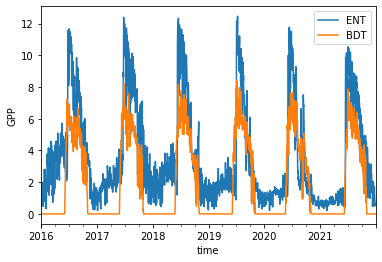

In [11]:
df1.sim_GPP.plot(label='ENT') ;
df2.sim_GPP.plot(label='BDT') ;
plt.ylabel('GPP');
plt.legend() ;

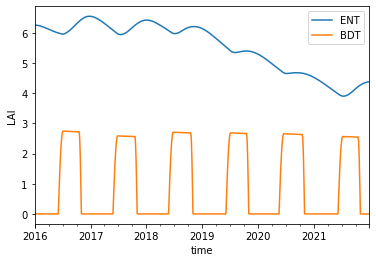

In [12]:
df1.sim_ELAI.plot(label='ENT') ;
df2.sim_ELAI.plot(label='BDT') ;
plt.ylabel('LAI');
plt.legend()


In [13]:
climo1 = df1.groupby(df1.time2.dt.dayofyear).mean()
climo2 = df2.groupby(df2.time2.dt.dayofyear).mean()
climo1SD = df1.groupby(df1.time2.dt.dayofyear).std()
climo2SD = df2.groupby(df2.time2.dt.dayofyear).std()
climo1.var()

sim_QVEGT          7.612738e-11
sim_QVEGE          5.040761e-12
sim_QSOIL          1.428320e-13
sim_RAIN           1.694962e-10
sim_SNOW           5.623734e-10
sim_Vcmx25Z        5.448288e+01
sim_AR             7.954230e-01
sim_ESAI           0.000000e+00
sim_HTOP           1.361325e-04
sim_ELAI           2.593255e-02
sim_FCEV           3.152996e+01
sim_FCTR           4.761768e+02
sim_FGEV           8.955892e-01
sim_FIRA           1.864355e+02
sim_FSA            3.328667e+03
sim_FSR            6.081036e+01
sim_FSDS           4.265845e+03
sim_FSH            1.293019e+03
sim_GPP            7.253402e+00
sim_H2OSOI         9.240332e-04
sim_HR             3.820276e+00
sim_SNOW_DEPTH     1.622973e-01
sim_TBOT           5.915313e+01
sim_TSOI           2.614165e+01
sim_BTRANMN                 NaN
sim_TV             5.216743e+01
sim_AGNPP          2.889708e-11
sim_EFLX_LH_TOT    4.414214e+02
sim_Rnet           2.979532e+03
sim_NEE            2.877460e-01
sim_ER             7.898760e+00
year    

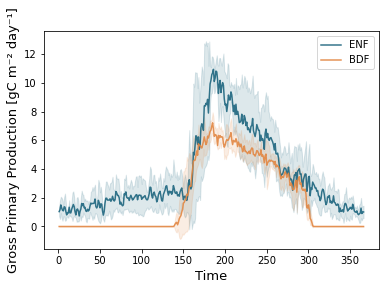

In [14]:
var = 'sim_GPP'
color1= '#e28743'
color2='#1d657e'

plot_var_desc = "Gross Primary Production"
plot_var_unit= "gC m⁻² day⁻¹"
#plot_var = var.obs_var
#sim_var = var.sim_var
#plot_var_desc = var.long_name
#lot_var_unit = var.unit
    
plt.plot ( climo1.DOY, climo1[var], color = color2, label="ENF", alpha = 0.9)
plt.plot ( climo2.DOY, climo2[var], color = color1,label="BDF", alpha = 0.9)
    
plt.fill_between(climo1.DOY, climo1[var]-climo1SD[var], climo1[var]+climo1SD[var],alpha=0.15, color = color2)
plt.fill_between(climo2.DOY, climo2[var]-climo2SD[var], climo2[var]+climo2SD[var] ,alpha=0.15, color = color1)

plt.xlabel('Time', fontsize=13)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=13)
plt.legend();
#    ax.margins(x=0.02)


In [15]:
class PlotVariable ():
  def __init__(self, short_name, long_name, unit):
    self.short_name = short_name
    self.long_name = long_name
    self.unit = unit
    self.obs_var = short_name
    self.sim_var = 'sim_'+short_name

In [16]:
all_vars= [] 

plot_var = 'SNOW_DEPTH'
sim_var = 'sim_'+plot_var
plot_var_desc = "Snow Depth"
plot_var_unit= "m"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'TSOI'
sim_var = plot_var
plot_var_desc = "Soil Temperature"
plot_var_unit= "deg C"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'H2OSOI'
sim_var = 'sim_'+plot_var
plot_var_desc = "Soil Moisture"
plot_var_unit= "$\mathrm{mm^{3}  mm^{-3}}$"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'GPP'
sim_var = 'sim_'+plot_var
plot_var_desc = "GPP"
plot_var_unit= "gC m⁻² day⁻¹"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)

plot_var = 'HR'
sim_var = 'sim_'+plot_var
plot_var_desc = "HR"
plot_var_unit= "gC m⁻² day⁻¹"
this_var = PlotVariable(plot_var, plot_var_desc, plot_var_unit)
all_vars.append(this_var)


$\mathrm{mm^{3}  mm^{-3}}$

In [22]:
def shaded_tseries(climo1, climo1SD, climo2, climo2SD, var, ax, ln, unit, color1= '#e28743',color2='#1d657e' ):
    
    var = var.sim_var
    plot_var_desc = ln
    plot_var_unit = unit
    
    ax.plot ( climo1.DOY, climo1[var], color = color2, label="Spruce", alpha = 0.9)
    ax.plot ( climo2.DOY, climo2[var], color = color1,label="Aspen", alpha = 0.9)
    
    ax.fill_between(climo1.DOY, climo1[var]-climo1SD[var], climo1[var]+climo1SD[var],alpha=0.15, color = color2)
    ax.fill_between(climo2.DOY, climo2[var]-climo2SD[var], climo2[var]+climo2SD[var] ,alpha=0.15, color = color1)

    ax.set_xlabel('Time', fontsize=13)
    ax.set_ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=13)
    ax.margins(x=0.02)


In [23]:
var in enumerate(all_vars)

False

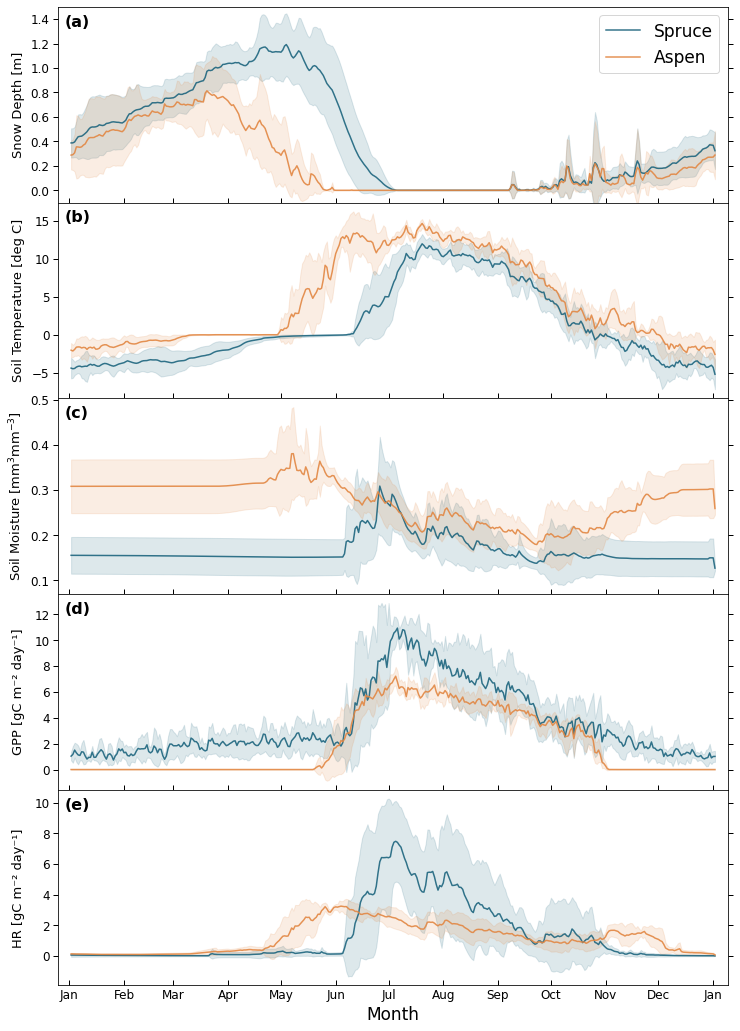

In [24]:
panel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)"]
import matplotlib.dates as mdates

fig = plt.figure(num=None, figsize=(12, 18),  facecolor='w', edgecolor='k')
axes = fig.subplots(nrows=5, ncols=1)
axe = axes.ravel()
for index, var in enumerate(all_vars):
    ax = axe[index]    
    ln = var.long_name
    unit = var.unit
    
    shaded_tseries ( climo1, climo1SD, climo2, climo2SD, var, ax, ln, unit)

    ax.text(.01,0.90,panel_labels[index],
        horizontalalignment='left',
        transform=ax.transAxes, fontweight='bold',fontsize=16)

    # Set the locator for boxplots
    locator = mdates.MonthLocator()  # every month

    # Specify the format - %b gives us Jan, Feb...
    fmt = mdates.DateFormatter('%b')            

    # add a title
    if index == 0:
    #    ax.text(.5,1.03,'NEON site : '+neon_site + ' [2018-2021]',
    #    horizontalalignment='center',
    #    transform=ax.transAxes, fontweight='bold',fontsize=19)
        ax.legend(fontsize = 17)
        ax.set_ylim([-0.1,1.5])

    ax.tick_params(axis='both', which='both', labelsize=12,width=1,length=5)
    ax.tick_params(axis='x',direction="in", length = 5)
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='y',direction="out", length = 5)

    X=ax.xaxis
    X.set_major_locator(locator)
    X.set_major_formatter(fmt)

    ax.get_yaxis().set_label_coords(-0.05,0.5)

    if index == 5:
        X = plt.gca().xaxis
        X.set_major_locator(locator)
        X.set_major_formatter(fmt)

ax.set_xlabel('Month', fontsize=17)
fig.subplots_adjust(wspace=0, hspace=0)

plt.show()

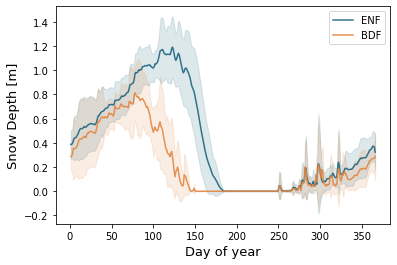

In [20]:
var = 'sim_SNOW_DEPTH'
color1= '#e28743'
color2='#1d657e'

plot_var_desc = "Snow Depth"
plot_var_unit= "m"
    
plt.plot ( climo1.DOY, climo1[var], color = color2, label="ENF", alpha = 0.9)
plt.plot ( climo2.DOY, climo2[var], color = color1,label="BDF", alpha = 0.9)
    
plt.fill_between(climo1.DOY, climo1[var]-climo1SD[var], climo1[var]+climo1SD[var],alpha=0.15, color = color2)
plt.fill_between(climo2.DOY, climo2[var]-climo2SD[var], climo2[var]+climo2SD[var] ,alpha=0.15, color = color1)

plt.xlabel('Day of year', fontsize=13)
plt.ylabel(plot_var_desc+" ["+plot_var_unit+"]", fontsize=13)
plt.legend();
#    ax.margins(x=0.02)


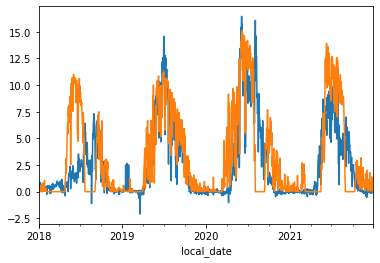

In [28]:
df_day.GPP.plot();
df_day.sim_GPP.plot();

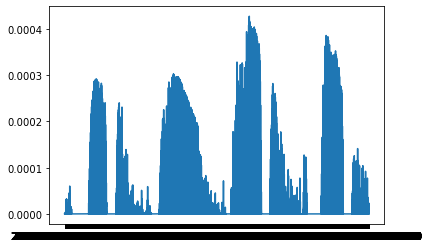

In [30]:
#ds_ctsm.FSDSNDLN.isel(lndgrid=0).plot() ;
plt.plot(ds_ctsm.time, ds_ctsm.GPP.isel(lndgrid=0)) ;